In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

def safelog2(x):
    if x == 0:
        return(0)
    else:
        return(np.log2(x))

In [2]:
# read data into memory
data_set = np.genfromtxt("hw05_data_set.csv", delimiter = ",", skip_header = 1)

# divide data set into two parts: training set and test set
X_training = data_set[0:150, 0]
X_test = data_set[150:, 0]
Y_training = data_set[0:150, 1].astype(int)
Y_test = data_set[150:, 1].astype(int)

# get number of classes and number of samples
K = np.max(data_set[:, 1].astype(int))

In [3]:
def calc_RMSE(y_pred, y_truth):
    res = np.sqrt(np.sum(np.square(y_truth - y_pred)) / len(y_truth))
    return res

In [4]:
def learn_tree(x, y, P):
    # create necessary data structures
    node_indices = {}
    is_terminal = {}
    need_split = {}

    node_splits = {}
    node_means = {}

    # put all training instances into the root node
    node_indices[1] = np.array(range(len(x)))
    is_terminal[1] = False
    need_split[1] = True

    # learning algorithm
    while True:
        # find nodes that need splitting
        split_nodes = [key for key, value in need_split.items() if value == True]
        
        # check whether we reach all terminal nodes
        if len(split_nodes) == 0:
            break
            
        # find best split positions for all nodes
        for split_node in split_nodes:
            data_indices = node_indices[split_node]
            need_split[split_node] = False
            node_means[split_node] = np.mean(y[data_indices])
            
            # pre-pruning
            if data_indices.size <= P:
                is_terminal[split_node] = True
            else:
                is_terminal[split_node] = False

                unique_values = np.sort(np.unique(x[data_indices]))
                split_positions = (unique_values[1:len(unique_values)] + unique_values[0:(len(unique_values) - 1)]) / 2
                split_scores = np.repeat(0.0, len(split_positions))
                
                for s in range(len(split_positions)):
                    left_indices = data_indices[x[data_indices] > split_positions[s]]
                    right_indices = data_indices[x[data_indices] <= split_positions[s]]
                    split_scores[s] = -len(left_indices) / len(data_indices) * (np.mean(y[left_indices]) * safelog2(np.mean(y[left_indices]))) - len(right_indices) / len(data_indices) * (np.mean(y[right_indices]) * safelog2(np.mean(y[right_indices])))
                
                best_score = np.min(split_scores)
                best_split = split_positions[np.argmin(split_scores)]
                
                node_splits[split_node] = best_split

                # create left node using the selected split
                left_indices = data_indices[x[data_indices] > best_split]
                node_indices[2 * split_node] = left_indices
                is_terminal[2 * split_node] = False
                need_split[2 * split_node] = True

                # create right node using the selected split
                right_indices = data_indices[x[data_indices] <= best_split]
                node_indices[2 * split_node + 1] = right_indices
                is_terminal[2 * split_node + 1] = False
                need_split[2 * split_node + 1] = True
                
    return node_means, node_splits, is_terminal

In [5]:
def predict(x, node_means, node_splits, is_terminal):
    ind = 1 # starting from root
    while True:
        if is_terminal[ind] == True:
            return node_means[ind]
        elif x > node_splits[ind]:
            ind = ind * 2 # left child
        else:
            ind = ind * 2 + 1 # right child

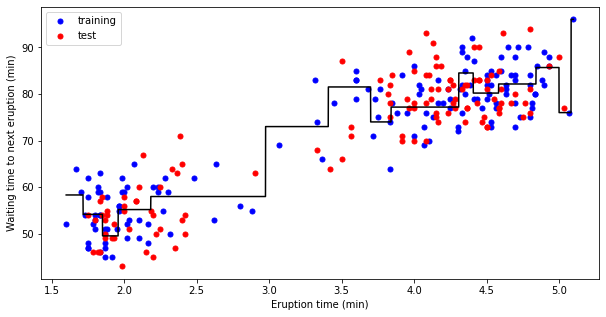

In [6]:
P = 25

node_means, node_splits, is_terminal = learn_tree(X_training, Y_training, P)

minval = min(data_set[:, 0])
maxval = max(data_set[:, 0])
data_interval = np.arange(minval, maxval, 0.001)

fig = plt.figure(figsize = (10,5))
plt.plot(X_training, Y_training, "b.", label = "training", markersize = 10)
plt.plot(X_test, Y_test, "r.", label = "test", markersize = 10)

pred = []
for i in range(len(data_interval)):
    pred.append(predict(data_interval[i],node_means, node_splits, is_terminal))
plt.plot(data_interval, pred, color="black")

plt.xlabel("Eruption time (min)")
plt.ylabel("Waiting time to next eruption (min)")
plt.legend(loc = "upper left")
plt.show()

In [7]:
pred_training = np.array([predict(x, node_means, node_splits, is_terminal) for x in X_training])
pred_test = np.array([predict(x, node_means, node_splits, is_terminal) for x in X_test])

RMSE_training = calc_RMSE(pred_training, Y_training)
RMSE_test = calc_RMSE(pred_test, Y_test)
print("RMSE on training set is {} when P is {}".format(RMSE_training, P))
print("RMSE on test set is {} when P is {}".format(RMSE_test, P))

RMSE on training set is 4.541214189194451 when P is 25
RMSE on test set is 6.454083413352087 when P is 25


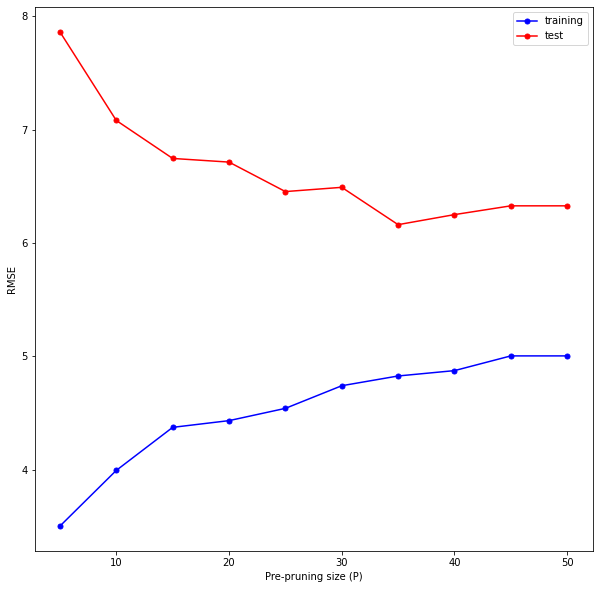

In [8]:
RMSE_training = []
RMSE_test = []
for P in range(5,51,5):
    node_means, node_splits, is_terminal = learn_tree(X_training, Y_training, P)
    pred_training = np.array([predict(x, node_means, node_splits, is_terminal) for x in X_training])
    pred_test = np.array([predict(x, node_means, node_splits, is_terminal) for x in X_test])
    RMSE_training.append(calc_RMSE(pred_training, Y_training))
    RMSE_test.append(calc_RMSE(pred_test, Y_test))
RMSE_training = np.array(RMSE_training)
RMSE_test = np.array(RMSE_test)

fig = plt.figure(figsize = (10,10))
plt.plot(range(5,51,5), RMSE_training, "b.-", label = "training", markersize = 10)
plt.plot(range(5,51,5), RMSE_test, "r.-", label = "test", markersize = 10)

plt.xlabel("Pre-pruning size (P)")
plt.ylabel("RMSE")
plt.legend(loc = "upper right")
plt.show()